# HAPPINESS
___

STAT 201 - Group 12: Anne Nguyen, Eric Pien, Oliver Gullery, Ruby Yang




## Introduction
___

Happiness, a subjective assessment of an individual’s emotional state/life satisfaction, can be affected by factors such as health and social network. As such, happiness can often act as an indicator for societal well-being (1). This report investigates how the COVID-19 pandemic has affected the happiness of the world population. Ultimately, we hope to answer the question: **Did Covid-19 negatively impact levels of happiness**?

We use data from the  *World Happiness Report* (2) where happiness scores are assessed using the Cantril ladder – a  subjective measure for wellbeing. Scores range from 0 to 10, representing the worst and best possible life respectively. We will compare the `mean` and `standard deviation` in happiness score for years before and after the COVID-19 pandemic to examine overall changes in world happiness.  

## Method & Results ##
___

### Data Loading, Cleaning, Splitting ###

In [2]:
# Environment Setup
install.packages('janitor')
library(tidyverse)
library(tidymodels)
library(GGally)
library(gridExtra)
library(janitor)
library(cowplot)

options(repr.matrix.max.rows = 6) #limits output of dataframes to 6 rows

also installing the dependency ‘snakecase’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done


Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test




In [3]:
# Read data from the web into R
data <- read_csv('https://raw.githubusercontent.com/ericpien/stat-201-project/main/data/DataForTable2.1.csv',skip=0)

# Clean/Wrangle Data
happiness_data <- data |>
    clean_names() |>
    as_tibble() |>
    drop_na()

# Create n_tile clusters by the year
n_tile <- 4

happiness_data <- happiness_data |>
    group_by(year) |>
    mutate(life_ladder_ntile = ntile(-life_ladder,n_tile),
            log_gdp_per_capita_ntile = ntile(-log_gdp_per_capita,n_tile),
            social_support_ntile = ntile(-social_support,n_tile),
            healthy_life_expectancy_at_birth_ntile = ntile(-healthy_life_expectancy_at_birth,n_tile),
            freedom_to_make_life_choices_ntile = ntile(-freedom_to_make_life_choices,n_tile),
            generosity_ntile = ntile(-generosity,n_tile),
            perceptions_of_corruption_ntile = ntile(-perceptions_of_corruption,n_tile),
            positive_affect_ntile = ntile(-positive_affect,n_tile),
            negative_affect_ntile = ntile(-negative_affect,n_tile),
            confidence_in_national_government_ntile = ntile(-confidence_in_national_government,n_tile))

# Create wide dataframe of mean happiness
happiness_data_wide_life_ladder <- happiness_data |> 
    group_by(country_name,year) |>
    summarize(life_ladder = life_ladder) |>
    pivot_wider(names_from = year,
                values_from = life_ladder)

Rows: 2089 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Country name
dbl (11): year, Life Ladder, Log GDP per capita, Social support, Healthy lif...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'country_name'. You can override using the
`.groups` argument.


### Preliminary Data Exploration ###

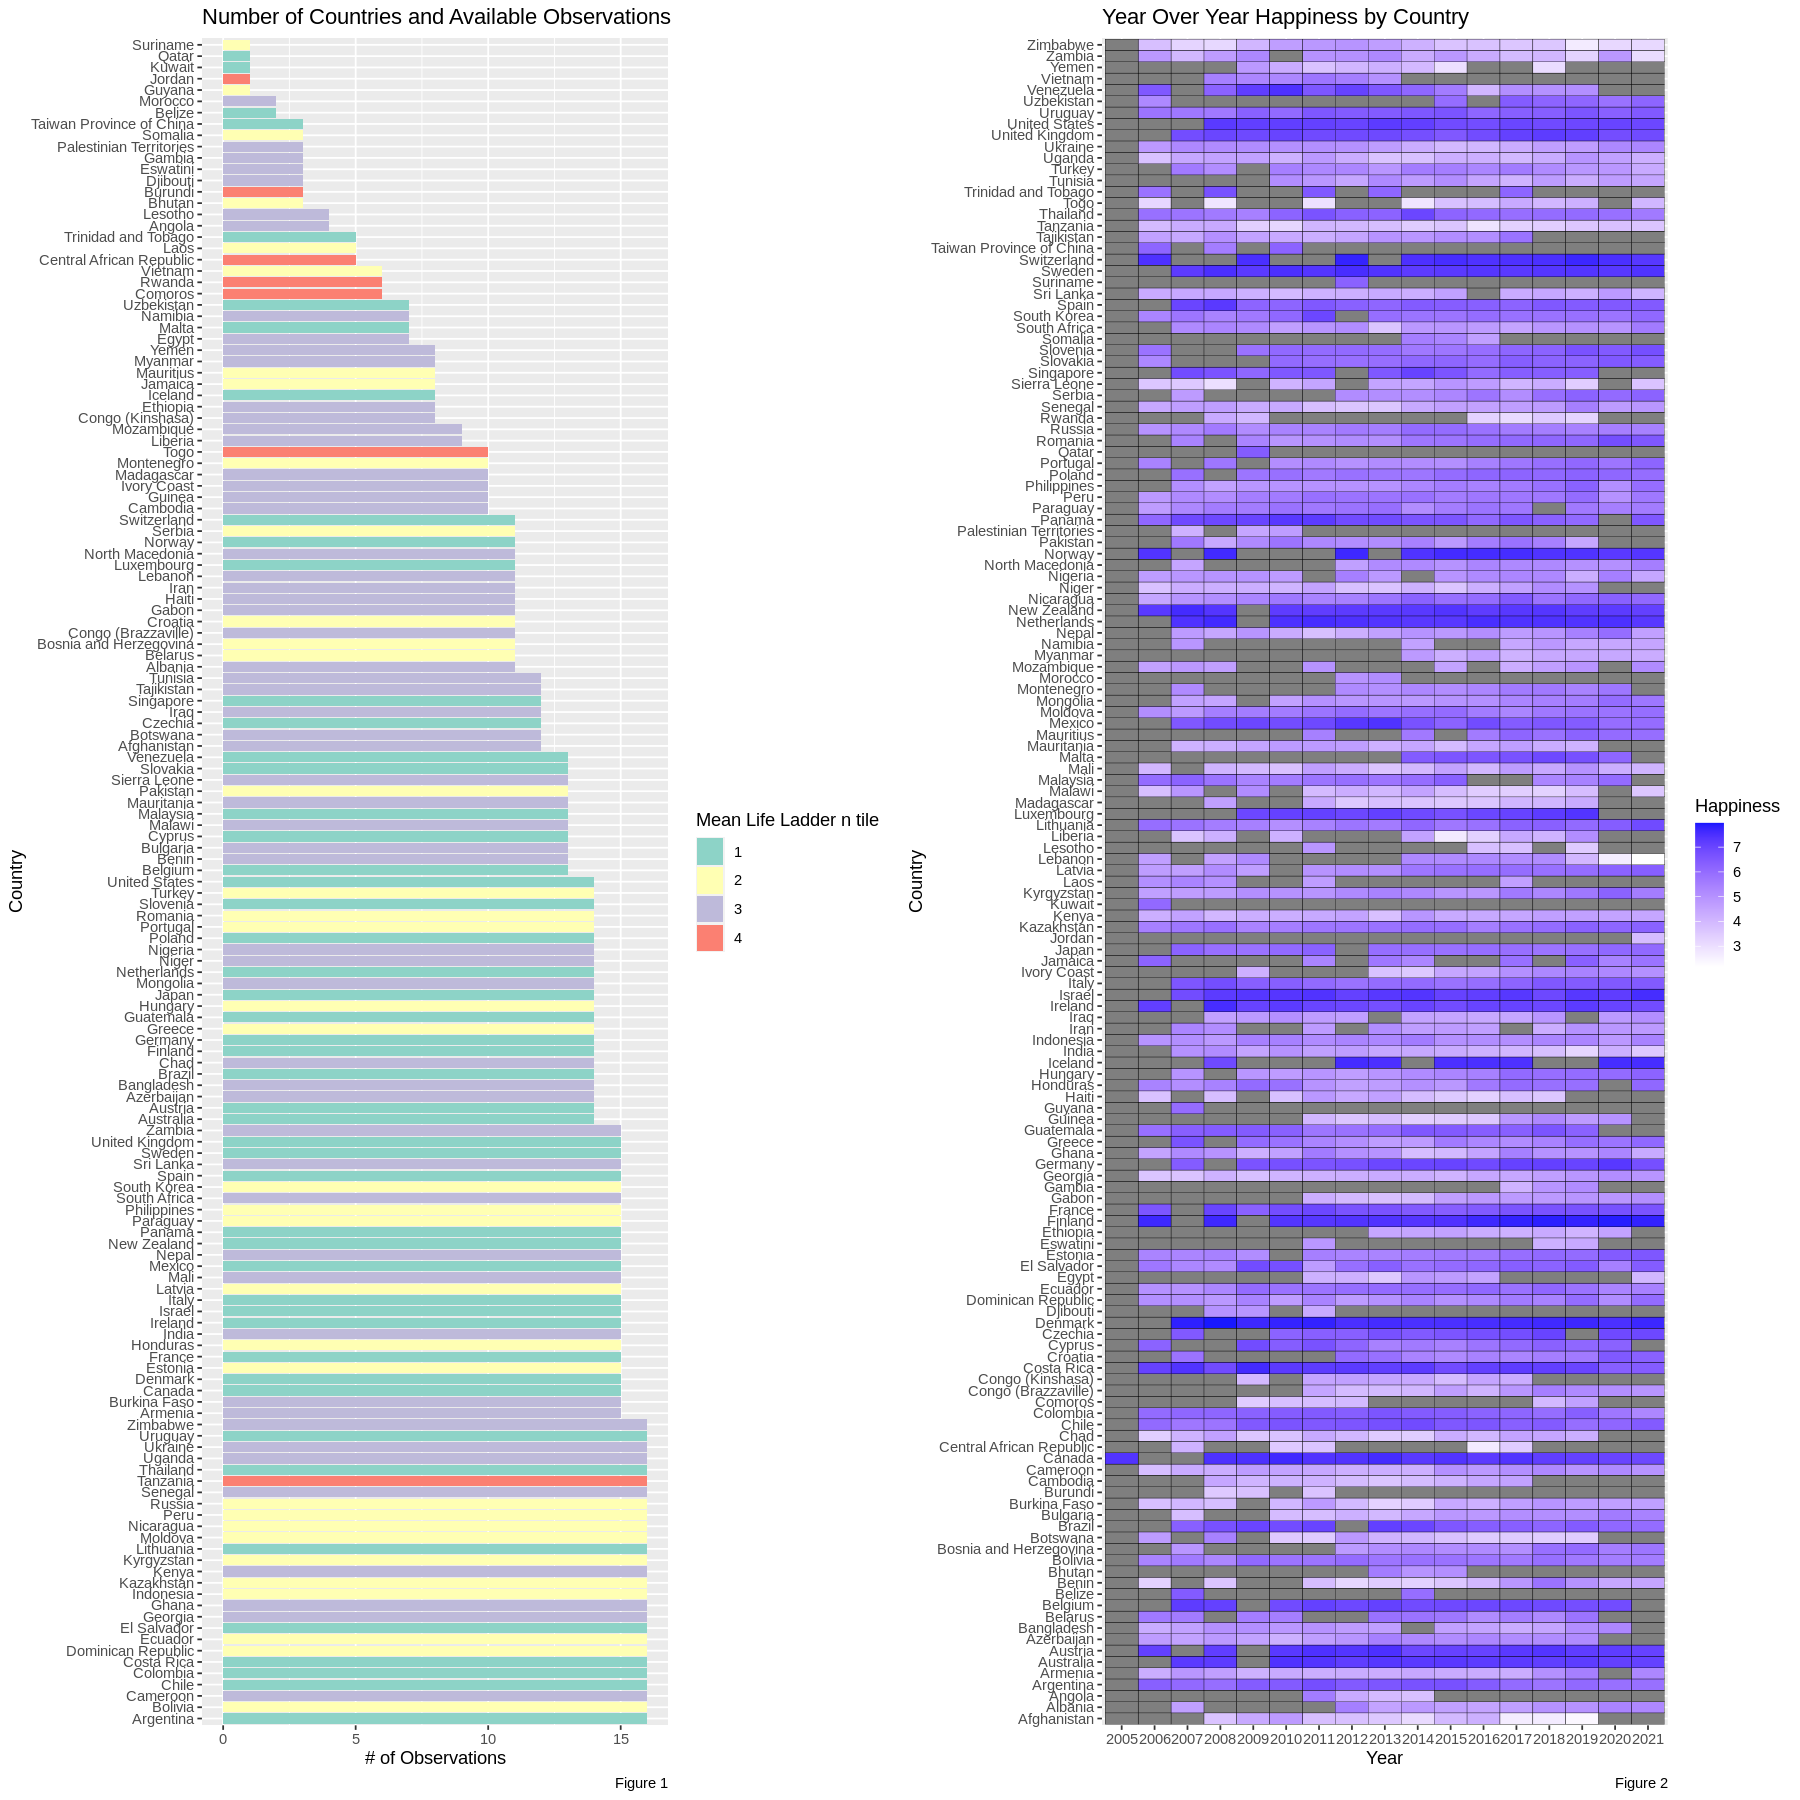

In [4]:
# Number of countries and available data
options(repr.plot.width = 15, repr.plot.height = 15) 

happiness_data_obs <- happiness_data |> 
    group_by(country_name) |> 
    summarize(obs_count=n(),
                mean_cluster = as.integer(mean(life_ladder_ntile))) |>
    arrange(-obs_count) |>
    ggplot(aes(x=obs_count,y=fct_inorder(country_name),fill = factor(mean_cluster))) +
    geom_col() +
    scale_fill_brewer(palette="Set3") +
    labs(x="# of Observations", y="Country", fill="Mean Life Ladder n tile", title="Number of Countries and Available Observations", caption = "Figure 1")

#happiness_data_obs # Chart displayed as a group below

# YoY happiness metric heatmap
happiness_heatmap <- happiness_data_wide_life_ladder |>
    pivot_longer(cols=-country_name,names_to="year",values_to ="life_ladder") |>
    ggplot(aes(x=year, y=country_name)) +
    geom_tile(aes(fill=life_ladder), color="black") +
    scale_fill_gradient(low="white", high="#1818ff") +
    labs(x="Year", y="Country", fill="Happiness", title="Year Over Year Happiness by Country", caption = "Figure 2")

#happiness_heatmap # Chart displayed as a group below
plot_grid(happiness_data_obs,happiness_heatmap,ncol = 2)

### 2019, 2020, 2021 Data ###

In [5]:
# Create a list of countries that have data for 2019 and 2021
country_name_2019_2021  <- happiness_data |>
    group_by(country_name) |>
    filter(year %in% c(2019,2021)) |>
    drop_na() |>
    summarise(n=n()) |>
    filter(n>1) |>
    pull(country_name)

# Select the countries and filter for 2019 and 2021 data
happiness_data_2019_2021 <- happiness_data |>
    filter(country_name %in% country_name_2019_2021,
            year %in% c(2019,2021))

# Summarize the estimates of the parameters (mean and sd) across the groups (2019 and 2021)
happiness_data_2019_2021 |> group_by(year) |> summarise(mean_happiness = mean(life_ladder), sd = sd(life_ladder))

year mean_happiness sd      
1 2019 5.737087       1.089441
2 2021 5.670313       1.138531

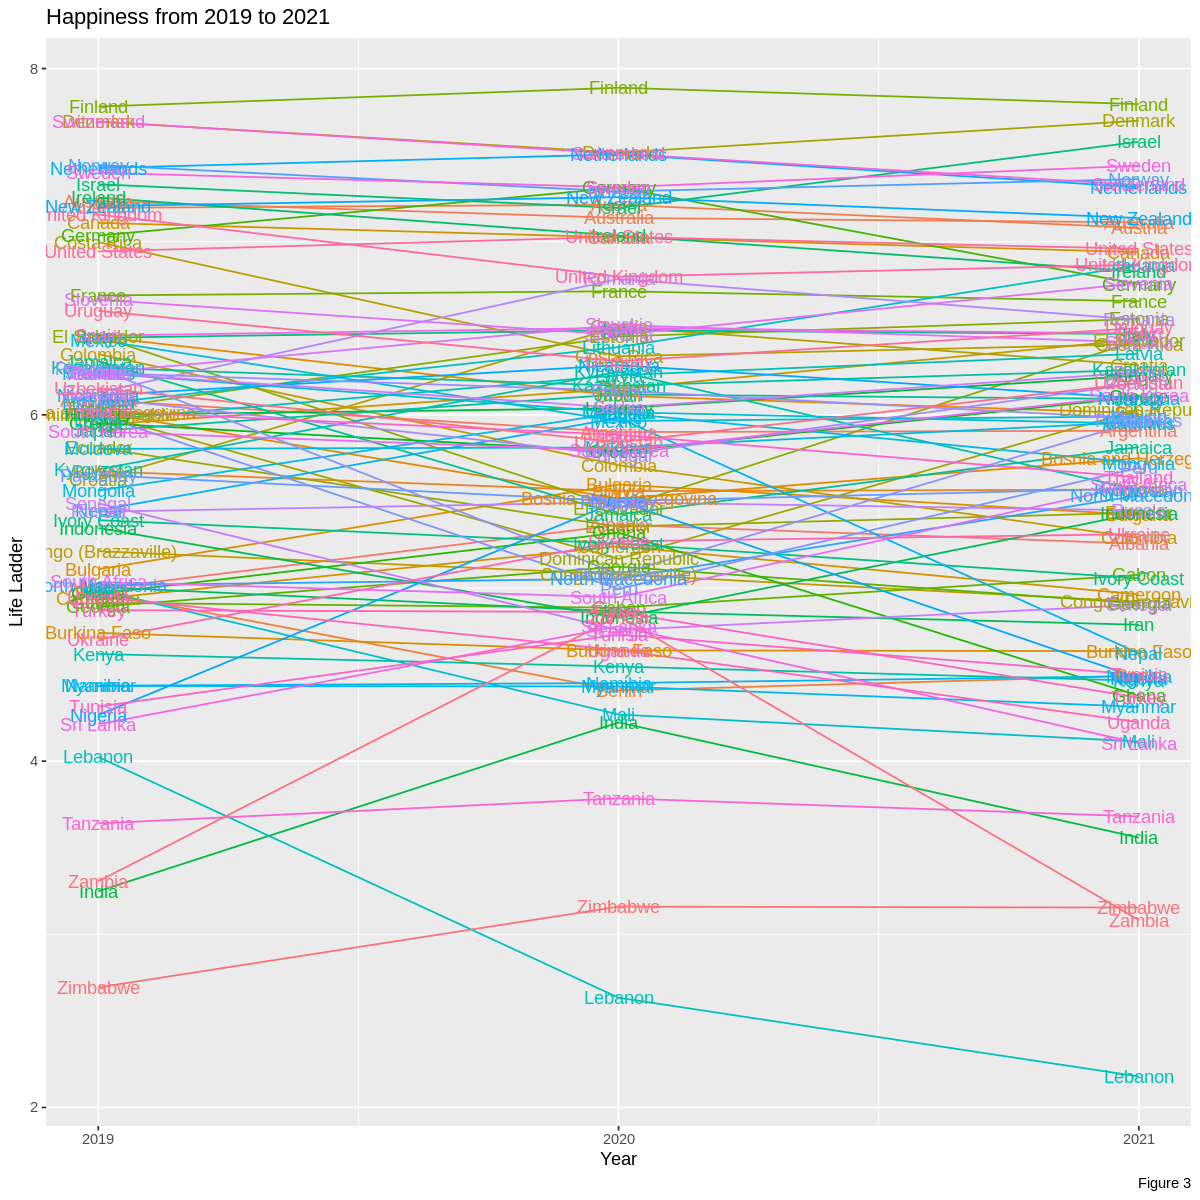

In [6]:
# Change from 2019, 2020, and 2021 happiness
options(repr.plot.width = 10, repr.plot.height = 10)

happiness_trail <- happiness_data_wide_life_ladder |> select(country_name,`2019`,`2020`,`2021`) |> drop_na() |> pivot_longer(cols=-country_name,names_to="year",values_to ="life_ladder") |> mutate(year = as.integer(year)) |>
    ggplot(aes(x=year, y=life_ladder, group=country_name, color=country_name)) +
    geom_line() +
    geom_text(aes(label = country_name)) +
    theme(legend.position="none") +
    labs(x="Year",y="Life Ladder",title="Happiness from 2019 to 2021", caption = "Figure 3") + 
    scale_x_continuous(breaks=c(2019,2020,2021), limits = c(2019,2021))
    
happiness_trail

[1] "Red line marks the point Estimate (mean change in happiness): -0.0667741624631579"

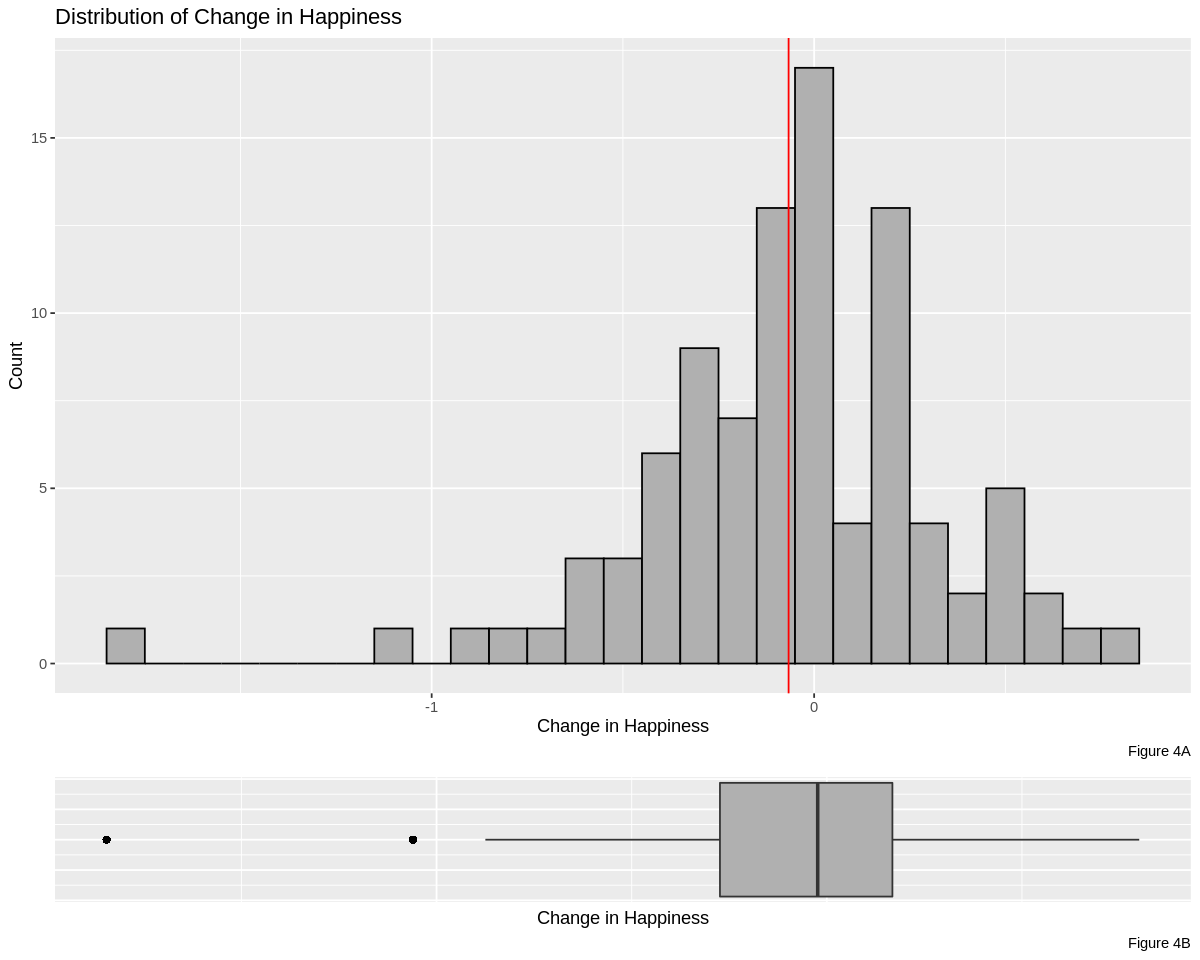

In [7]:
# Change Mean from 2021 to 2019
change_2019_2021 <- happiness_data_wide_life_ladder |>
    select(country_name,`2019`,`2021`) |>
    drop_na() |>
    group_by(country_name) |>
    mutate(change = `2021`-`2019`)

# Mean Change
mean_point_estimate <- mean(change_2019_2021$change)

# Print the mean change
sprintf("Red line marks the point Estimate (mean change in happiness): %0.16f", mean_point_estimate)

# Plot the Distribution
options(repr.plot.width = 10, repr.plot.height = 8) 
change_histogram <- change_2019_2021 |>
    ggplot(aes(x=change)) +
    geom_histogram(fill = "grey69", binwidth = 0.1, color="black") +
    geom_vline(xintercept=mean(change_2019_2021$change),color="red") +
    labs(x="Change in Happiness",y="Count",title="Distribution of Change in Happiness", caption = "Figure 4A")

# Plot the Box Plot
change_boxplot <- change_2019_2021 |>
        ggplot(aes(x=change)) +
        geom_boxplot(fill = "grey69", outlier.colour="black", outlier.shape=16,
                 outlier.size=2, notch=FALSE) +
        labs(x="Change in Happiness", caption = "Figure 4B") +
        theme(
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.text.x=element_blank(),
            axis.ticks.x=element_blank())

# Combine the boxplot and histogram together using cowplot
plot_grid(change_histogram, change_boxplot, ncol = 1, rel_heights = c(2, 0.5), align = 'v')

### Hypothesis testing ###

p_value
1 0.046

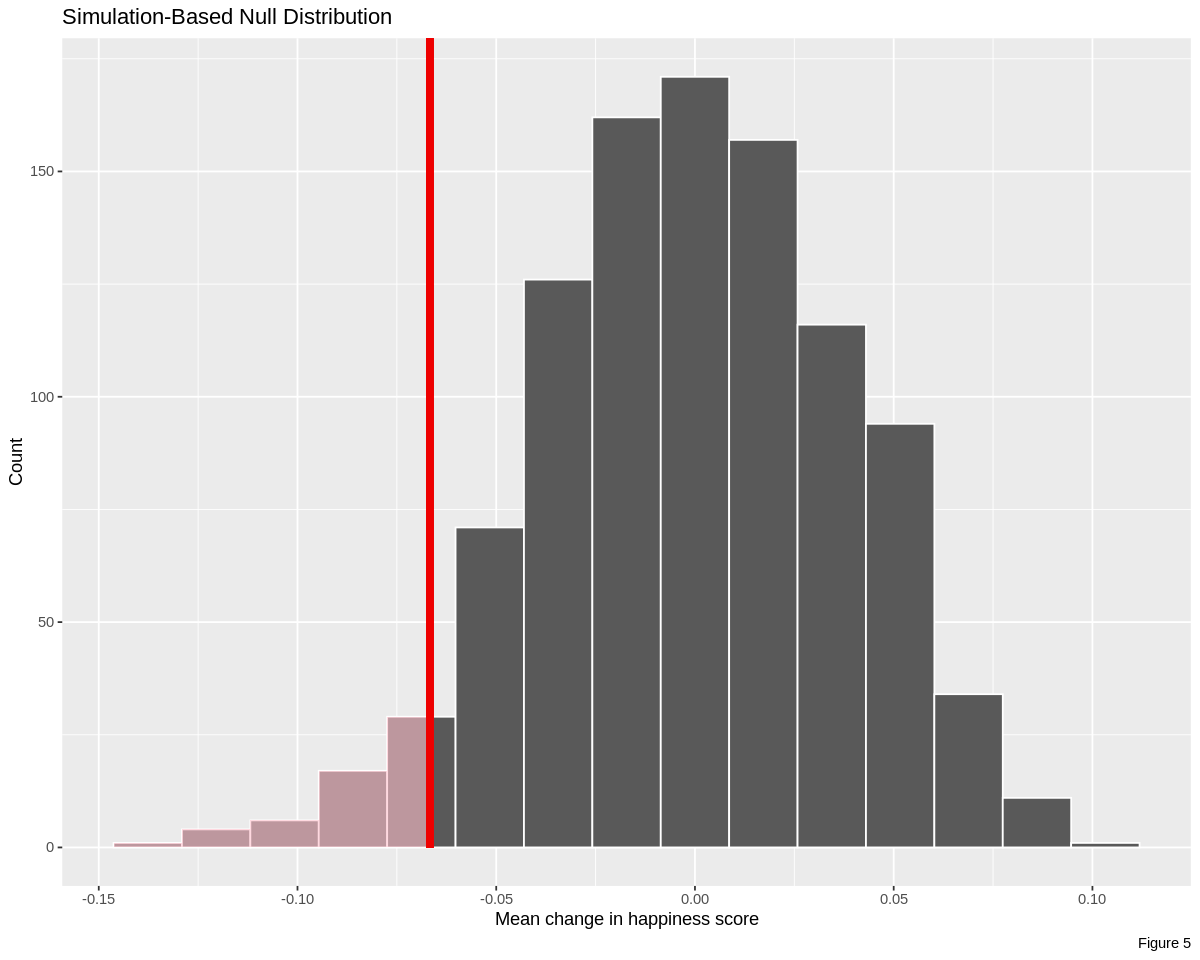

In [48]:
#Set seed for reproducibility
set.seed(201)

#Calculate observed mean change in happiness
obs_mean_change_in_happiness <- 
    change_2019_2021 %>%
    specify(response = change)  %>%
    calculate(stat = "mean")

#Generate null distribution for null mean change of 0
null_dist_change_in_happiness <-
    change_2019_2021 %>%
    specify(response = change)  %>%
    hypothesize(null = "point", mu = 0) %>%
    generate(reps = 1000, type = "bootstrap") %>%
    calculate(stat = "mean")

#Plot the null distribution with the observed mean change in happiness
null_change_in_happiness_plot <- 
    null_dist_change_in_happiness %>% 
    visualize() + 
    shade_p_value(obs_stat = obs_mean_change_in_happiness, direction = 'less') +
    labs(x = "Mean change in happiness score", y = "Count", caption = "Figure 5")
null_change_in_happiness_plot

#Calculate p-value from the null distribution
p_value <- 
    null_dist_change_in_happiness %>% 
    get_p_value(obs_stat = obs_mean_change_in_happiness, direction = "less")
p_value

### Confidence Interval ###

lower_ci      upper_ci       
1 -0.1304117435 -0.007783775023

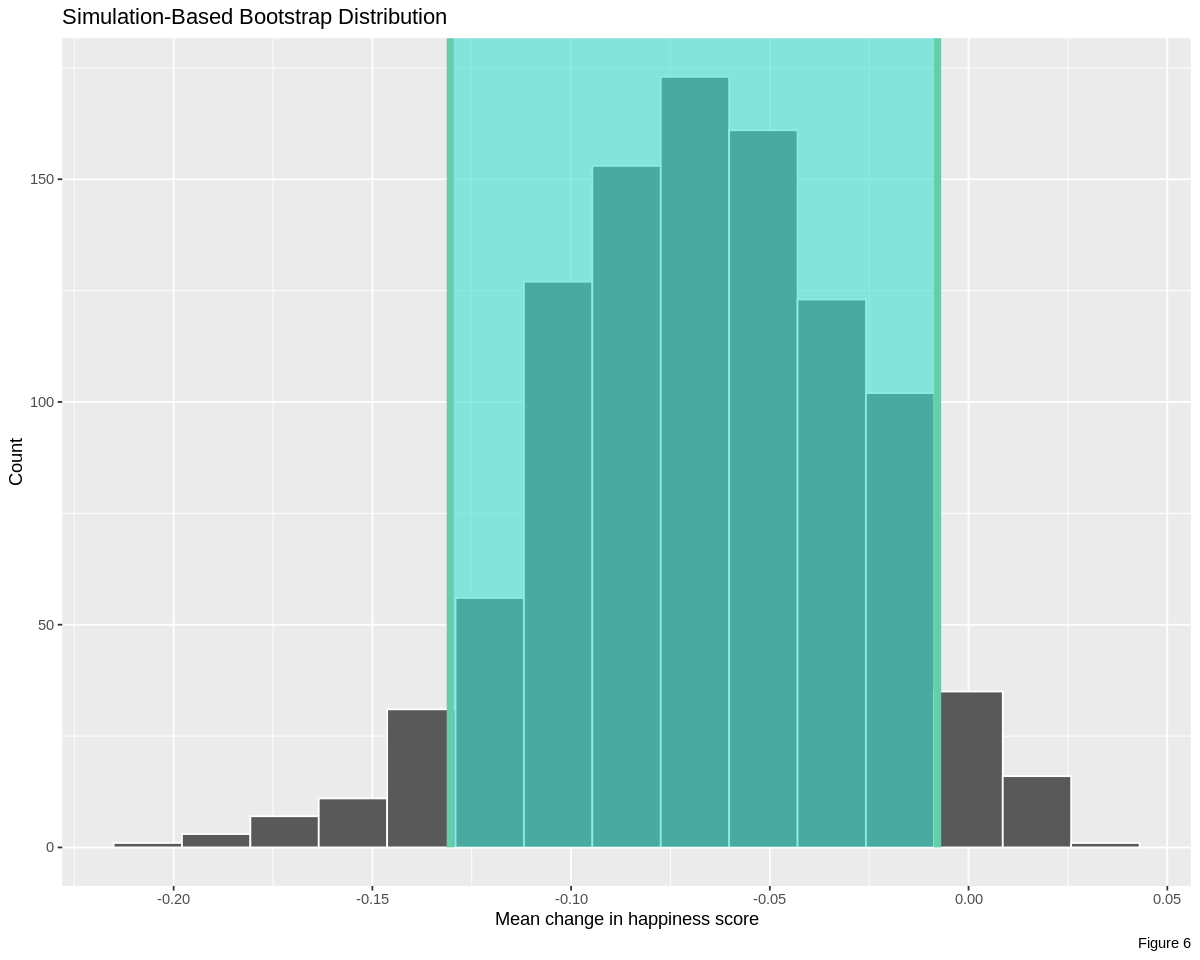

In [49]:
#Set seed for reproducibility
set.seed(201)

#Create bootstrap distribution
mean_change_in_happiness_boot_dist <-
    change_2019_2021 %>%
    specify(response = change)  %>%
    generate(reps = 1000, type = "bootstrap") %>%
    calculate(stat = "mean")

#Calculate confidence interval from bootstrap distribution
mean_change_in_happiness_ci <- 
    mean_change_in_happiness_boot_dist %>% 
    summarise(lower_ci = quantile(stat, 0.05), upper_ci = quantile(stat, 0.95))
mean_change_in_happiness_ci

#Visualize confidence interval on bootstrap distribution
change_in_happiness_boot_plot <- 
    mean_change_in_happiness_boot_dist %>% 
    visualize() + 
    shade_confidence_interval(endpoints = mean_change_in_happiness_ci) +
    labs(x = "Mean change in happiness score", y = "Count", caption = "Figure 6")
change_in_happiness_boot_plot

## Discussion
___

**The Good**\
Our analysis shows that the majority of countries did not observe a change in happiness greater than 0.5 to -0.5. This report is trustworthy since the data is up-to-date and collected by dedicated and experienced researchers (2).

**The Bad**\
The aforementioned mean change is insufficient because it lacks measures of uncertainty due to variance. Furthermore, by aggregating every country, we lose insights that may be revealed in different groupings like geographical regions. Lastly, we consider 2019 to be "before COVID-19" and 2021 to be "after COVID-19", but this may not be applicable to all countries' situations.

**The Solution**\
To include measures of uncertainty with our point estimate (mean change in happiness), we will perform hypothesis testing for establishing statistical significance of the results and calculate a confidence interval to quantify the errors when estimating the mean change in happiness between 2019 and 2021.

We will perform a paired T-test because the two datasets sample the same countries over an interval of time.

Our hypotheses are:  
$$
\begin{align*}
H_0&: \mu_{\text{2021}} - \mu_{\text{2019}} = 0 \\ 
H_1&: \mu_{\text{2021}} - \mu_{\text{2019}} < 0 \\ 
\end{align*}
$$
* **Null Hypothesis**: There is no change in mean Happiness before and after COVID-19 throughout most countries.
* **Alternative Hypothesis**: The mean happiness decreased after COVID-19 throughout most countries.

The significance level will be 0.05 with a corresponding confidence level of 95% (1- $\alpha$) to reduce the risk of type II errors. We will use the bootstrapping method with set.seed() for reproducibility as this does not require any assumptions about the population distribution (compared to using asymptotic approaches).

**Expected Findings**\
We expect that COVID-19 decreased happiness levels due to the effects of lockdown; studies done on the effects of vitamin D deficiency from lack of sunlight (3) and staying indoors (4) found negative impacts such as depression.

**Impacts**\
Understanding the quantitative impact on happiness could inform future quarantine response procedures. Exploring how certain policies or events affect happiness levels can guide organisations to make better decisions for everyone's happiness (5).

**Future Questions**
* How do different pandemic responses and policies affect happiness levels?
* How does happiness relate to other indicators of success and should it be given greater consideration in policy making? 

## References
___

1. Krys, K., Park, J., Kocimska-Zych, A. et al. (2021). Personal Life Satisfaction as a Measure of Societal Happiness is an Individualistic Presumption: Evidence from Fifty Countries. J Happiness Stud 22, 2197–2214. https://doi.org/10.1007/s10902-020-00311-y

2. Helliwell, J. F., Layard, R., Sachs, J. D., Neve, J.-E. D., Aknin, L. B., & Wang, S. (2021, March 20). World happiness report 2021. https://worldhappiness.report/ed/2021/

3. Anjum, I., Jaffery, S. S., Fayyaz, M., Samoo, Z., Anjum, S., Anjum, I., Jaffery, S. S., Fayyaz, M., Samoo, Z., & Anjum, S. (2018). The role of vitamin d in brain health: A mini literature review. Cureus, 10(7). https://doi.org/10.7759/cureus.2960

4. Thakur, K., Kumar, N., & Sharma, N. (2020). Effect of the pandemic and lockdown on mental health of children. The Indian Journal of Pediatrics, 87(7), 552–552. https://doi.org/10.1007/s12098-020-03308-w

5. Musikanski, L. (2014). Happiness in public policy. Journal of Sustainable Social Change, 6(1). https://scholarworks.waldenu.edu/jsc/vol6/iss1/5
